# Avance 5 – Modelo final (Equipo 41)

**Curso:** Proyecto Integrador  

**Institución:** Tecnológico de Monterrey  

**Equipo:** 41  

**Integrantes:**  
- Benitez Ortega, Luis Ángel — A01795165  
- Del Valle Azuara, Claudio Luis — A01795773  
- Islas Blanco, Alejandra — A01794452

**Objetivos del Avance 5**  
- **3.5** Mejorar significativamente el rendimiento al aprovechar ensambles (homogéneos y heterogéneos).  
- **3.6** Evaluar calidad en datos no vistos y justificar el **modelo final** con métricas y visualizaciones.  

In [1]:
import os, time, warnings, math, itertools, json
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
warnings.filterwarnings('ignore')

def fmt(v, nd=4):
    try:
        return f"{v:.{nd}f}"
    except Exception:
        return str(v)

class Stopwatch:
    def __init__(self):
        self.t0 = None
    def start(self):
        self.t0 = time.perf_counter()
    def stop(self):
        return time.perf_counter() - self.t0 if self.t0 else None

print('Reproducibilidad configurada. RANDOM_STATE =', RANDOM_STATE)


Reproducibilidad configurada. RANDOM_STATE = 42


In [2]:
DATA_DIR = Path('.').resolve()

def try_read(path_stem: str):
    csv = DATA_DIR / f"{path_stem}.csv"
    if csv.exists():
        return pd.read_csv(csv)
    raise FileNotFoundError(f"No se encontró {path_stem}.csv en {DATA_DIR}")

df = try_read('engineered_features')
try:
    df_raw = try_read('generated_converted')
except FileNotFoundError:
    df_raw = None

TARGET_COL = 'final_label'
assert TARGET_COL in df.columns, f"No se encuentra la columna objetivo '{TARGET_COL}' en engineered_features."
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print('Ruta de datos:', DATA_DIR)
print('df:', df.shape, '| X_train:', X_train.shape, '| X_test:', X_test.shape)
print('Distribución y_train:')
print(y_train.value_counts(normalize=True).sort_index())


Ruta de datos: C:\Users\Admin\Downloads\Avance 5
df: (161, 302) | X_train: (128, 301) | X_test: (33, 301)
Distribución y_train:
final_label
clarify     0.257812
continue    0.468750
handoff     0.273438
Name: proportion, dtype: float64


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_cols = list(X_train.columns)
preprocess = ColumnTransformer([
    ('num', StandardScaler(with_mean=False), num_cols),
], remainder='drop')

print('Número de variables numéricas:', len(num_cols))


Número de variables numéricas: 301


In [4]:
from sklearn.model_selection import StratifiedKFold, cross_validate, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

SCORING = ['f1_macro', 'accuracy', 'precision_macro', 'recall_macro']
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=RANDOM_STATE)

def eval_model(name, estimator, X, y, scoring=SCORING):
    pipe = Pipeline([('prep', preprocess), ('clf', estimator)])
    sw = Stopwatch(); sw.start()
    cv = cross_validate(pipe, X, y, cv=skf, scoring=scoring, n_jobs=-1, return_train_score=False)
    elapsed = sw.stop()
    row = {'model': name, 'cv_time_s': float(elapsed)}
    for m in scoring:
        row[f"{m}_mean"] = float(np.mean(cv[f"test_{m}"]))
        row[f"{m}_std"]  = float(np.std(cv[f"test_{m}"]))
    return row

print('Esquema CV listo:', skf)


Esquema CV listo: RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=42)


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

candidatos = {
    'logreg': LogisticRegression(max_iter=1000),
    'linsvc': LinearSVC(),
    'svc_rbf': SVC(probability=True),
    'rf': RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE),
    'hgb': HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    'knn': KNeighborsClassifier(),
    'nb': GaussianNB(),
    'dt': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'mlp': MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=RANDOM_STATE)
}

ind_results = []
for name, est in candidatos.items():
    try:
        row = eval_model(name, est, X_train, y_train, scoring=SCORING)
        ind_results.append(row)
        print(f"{name}: f1_macro={fmt(row['f1_macro_mean'])} ± {fmt(row['f1_macro_std'])} | time={fmt(row['cv_time_s'])}s")
    except Exception as e:
        print(f"[WARN] {name} falló: {e}")

df_ind = pd.DataFrame(ind_results).sort_values(by='f1_macro_mean', ascending=False).reset_index(drop=True)
df_ind


logreg: f1_macro=0.8071 ± 0.0599 | time=4.1232s
linsvc: f1_macro=0.8005 ± 0.0615 | time=0.1890s
svc_rbf: f1_macro=0.7316 ± 0.0810 | time=0.1714s
rf: f1_macro=0.8143 ± 0.0647 | time=2.1079s
hgb: f1_macro=0.8007 ± 0.0848 | time=7.0830s
knn: f1_macro=0.4516 ± 0.1129 | time=0.3497s
nb: f1_macro=0.7829 ± 0.0616 | time=0.1411s
dt: f1_macro=0.8078 ± 0.1006 | time=0.1569s
mlp: f1_macro=0.6155 ± 0.1082 | time=1.0142s


,model,cv_time_s,f1_macro_mean,f1_macro_std,accuracy_mean,accuracy_std,precision_macro_mean,precision_macro_std,recall_macro_mean,recall_macro_std
0,rf,2.107868,0.814335,0.064710,0.854831,0.048518,0.844397,0.061503,0.820317,0.060521
1,dt,0.156889,0.807826,0.100553,0.841046,0.081398,0.823562,0.103229,0.808730,0.098002
2,logreg,4.123160,0.807133,0.059906,0.844000,0.044572,0.844035,0.049883,0.806667,0.055437
3,hgb,7.083019,0.800697,0.084774,0.840800,0.063811,0.819024,0.087957,0.805238,0.082386
4,linsvc,0.189028,0.800500,0.061461,0.839077,0.048676,0.828318,0.057139,0.805397,0.058337
5,nb,0.141132,0.782922,0.061594,0.822154,0.053289,0.802202,0.069009,0.787460,0.062119
6,svc_rbf,0.171386,0.731566,0.081029,0.790646,0.050414,0.788097,0.094818,0.736825,0.064980
7,mlp,1.014216,0.615542,0.108250,0.687877,0.083074,0.640690,0.131757,0.622063,0.094116
8,knn,0.349668,0.451591,0.112904,0.589231,0.067571,0.571312,0.182937,0.485873,0.085494


## 6) Ensambles homogéneos y heterogéneos

In [6]:
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier

# Compatibilidad versiones scikit-learn (>=1.2 usa 'estimator', <=1.1 usa 'base_estimator')
def make_bagging_logreg():
    from sklearn.linear_model import LogisticRegression
    try:
        return BaggingClassifier(
            estimator=LogisticRegression(max_iter=1000),
            n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1
        )
    except TypeError:
        return BaggingClassifier(
            base_estimator=LogisticRegression(max_iter=1000),
            n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1
        )

homog_estimators = {
    'bagging_logreg': make_bagging_logreg(),
    'rf_500': RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1),
    'extratrees_500': ExtraTreesClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1),
    'hgb_default': HistGradientBoostingClassifier(random_state=RANDOM_STATE),
}

homog_results = []
for name, est in homog_estimators.items():
    try:
        row = eval_model(name, est, X_train, y_train)
        homog_results.append(row)
        print(f"{name}: f1_macro={fmt(row['f1_macro_mean'])} ± {fmt(row['f1_macro_std'])} | time={fmt(row['cv_time_s'])}s")
    except Exception as e:
        print(f"[WARN] {name} falló: {e}")

df_homog = pd.DataFrame(homog_results).sort_values(by='f1_macro_mean', ascending=False).reset_index(drop=True)
df_homog


bagging_logreg: f1_macro=0.7711 ± 0.0718 | time=2.5988s
rf_500: f1_macro=0.8214 ± 0.0636 | time=3.1069s
extratrees_500: f1_macro=0.8509 ± 0.0658 | time=2.2930s
hgb_default: f1_macro=0.8007 ± 0.0848 | time=6.9629s


,model,cv_time_s,f1_macro_mean,f1_macro_std,accuracy_mean,accuracy_std,precision_macro_mean,precision_macro_std,recall_macro_mean,recall_macro_std
0,extratrees_500,2.293035,0.850863,0.065823,0.883138,0.051165,0.875090,0.060725,0.854921,0.063829
1,rf_500,3.106898,0.821369,0.063637,0.859508,0.047909,0.849450,0.057749,0.826349,0.060080
2,hgb_default,6.962946,0.800697,0.084774,0.840800,0.063811,0.819024,0.087957,0.805238,0.082386
3,bagging_logreg,2.598844,0.771070,0.071802,0.812615,0.053998,0.828061,0.057080,0.765397,0.068312


In [7]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

base_logreg = LogisticRegression(max_iter=1000, C=3.0, solver='liblinear')
base_linsvc = LinearSVC(C=0.1)
base_linsvc_cal = CalibratedClassifierCV(base_linsvc, method='sigmoid', cv=3)

voting_soft = VotingClassifier(
    estimators=[('lr', base_logreg), ('lsvc', base_linsvc_cal)],
    voting='soft', n_jobs=-1
)
voting_hard = VotingClassifier(
    estimators=[('lr', base_logreg), ('lsvc', base_linsvc)],
    voting='hard', n_jobs=-1
)
stack_lr = StackingClassifier(
    estimators=[('lr', base_logreg), ('lsvc', base_linsvc_cal)],
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=False, n_jobs=-1
)

def blending_meta(X_tr, y_tr, estimators, meta_estimator, test_size=0.2, random_state=RANDOM_STATE):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    tr_idx, hold_idx = next(sss.split(X_tr, y_tr))
    X_b_tr, y_b_tr = X_tr.iloc[tr_idx], y_tr.iloc[tr_idx]
    X_b_hold, y_b_hold = X_tr.iloc[hold_idx], y_tr.iloc[hold_idx]

    fitted = []
    for name, est in estimators:
        pipe = Pipeline([('prep', preprocess), ('clf', clone(est))])
        pipe.fit(X_b_tr, y_b_tr)
        fitted.append((name, pipe))

    meta_features = []
    for name, pipe in fitted:
        try:
            proba = pipe.predict_proba(X_b_hold)
            meta_features.append(proba)
        except Exception:
            try:
                dfc = pipe.decision_function(X_b_hold)
                if getattr(dfc, 'ndim', 1) == 1:
                    dfc = dfc.reshape(-1, 1)
                meta_features.append(dfc)
            except Exception:
                pred = pipe.predict(X_b_hold).reshape(-1, 1)
                meta_features.append(pred)
    import numpy as _np
    Z_hold = _np.hstack(meta_features)

    meta = clone(meta_estimator)
    meta.fit(Z_hold, y_b_hold)

    def predict_fn(X):
        feats = []
        for _, pipe in fitted:
            try:
                proba = pipe.predict_proba(X)
                feats.append(proba)
            except Exception:
                try:
                    dfc = pipe.decision_function(X)
                    if getattr(dfc, 'ndim', 1) == 1:
                        dfc = dfc.reshape(-1, 1)
                    feats.append(dfc)
                except Exception:
                    feats.append(pipe.predict(X).reshape(-1, 1))
        Z = _np.hstack(feats)
        try:
            return meta.predict(Z), meta.predict_proba
        except Exception:
            return meta.predict(Z), None

    return fitted, meta, predict_fn

hetero_estimators = {
    'vote_soft': voting_soft,
    'vote_hard': voting_hard,
    'stack_lr': stack_lr,
}

hetero_results = []
for name, est in hetero_estimators.items():
    try:
        row = eval_model(name, est, X_train, y_train)
        hetero_results.append(row)
        print(f"{name}: f1_macro={fmt(row['f1_macro_mean'])} ± {fmt(row['f1_macro_std'])} | time={fmt(row['cv_time_s'])}s")
    except Exception as e:
        print(f"[WARN] {name} falló: {e}")

from sklearn.model_selection import train_test_split
sw = Stopwatch(); sw.start()
try:
    fitted, meta, predict_fn = blending_meta(
        X_train, y_train,
        estimators=[('lr', base_logreg), ('lsvc', base_linsvc_cal)],
        meta_estimator=LogisticRegression(max_iter=1000)
    )
    elapsed = sw.stop()

    X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE+7
    )
    fitted2, meta2, predict_fn2 = blending_meta(
        X_tr2, y_tr2,
        estimators=[('lr', base_logreg), ('lsvc', base_linsvc_cal)],
        meta_estimator=LogisticRegression(max_iter=1000)
    )
    y_pred_val, _ = predict_fn2(X_val2)
    row = {
        'model': 'blend_lr_on(lr,lsvc)',
        'cv_time_s': float(elapsed),
        'f1_macro_mean': float(f1_score(y_val2, y_pred_val, average='macro')),
        'f1_macro_std': 0.0,
        'accuracy_mean': float(accuracy_score(y_val2, y_pred_val)),
        'accuracy_std': 0.0,
        'precision_macro_mean': float(precision_score(y_val2, y_pred_val, average='macro')),
        'precision_macro_std': 0.0,
        'recall_macro_mean': float(recall_score(y_val2, y_pred_val, average='macro')),
        'recall_macro_std': 0.0,
    }
    hetero_results.append(row)
    print(f"blending: f1_macro={fmt(row['f1_macro_mean'])} | time={fmt(row['cv_time_s'])}s (holdout)")
except Exception as e:
    print('[WARN] blending falló:', e)

df_hetero = pd.DataFrame(hetero_results).sort_values(by='f1_macro_mean', ascending=False).reset_index(drop=True)
df_hetero


vote_soft: f1_macro=0.8111 ± 0.0687 | time=0.3313s
vote_hard: f1_macro=0.8028 ± 0.0594 | time=0.2542s
stack_lr: f1_macro=0.8122 ± 0.0642 | time=0.9465s
blending: f1_macro=0.7102 | time=0.0790s (holdout)


,model,cv_time_s,f1_macro_mean,f1_macro_std,accuracy_mean,accuracy_std,precision_macro_mean,precision_macro_std,recall_macro_mean,recall_macro_std
0,stack_lr,0.946521,0.812246,0.064204,0.848677,0.048928,0.841311,0.058032,0.816349,0.060666
1,vote_soft,0.331337,0.811137,0.068709,0.848738,0.052285,0.843522,0.059575,0.815079,0.065147
2,vote_hard,0.254233,0.802849,0.059356,0.842338,0.044019,0.836024,0.052197,0.808254,0.054000
3,"blend_lr_on(lr,lsvc)",0.078988,0.710152,0.000000,0.769231,0.000000,0.742877,0.000000,0.714286,0.000000


In [8]:
# === Métricas de calibración (opcional) ===
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibrationDisplay

def report_brier(estimator, X_eval, y_eval, model_name="modelo"):
    try:
        proba = estimator.predict_proba(X_eval)
        if proba.shape[1] == 2:
            bs = brier_score_loss(y_eval, proba[:,1], pos_label=sorted(y_eval.unique())[1])
            print(f"Brier score ({model_name}): {bs:.4f}")
        else:
            # promedio macro de Brier
            bs_list = []
            classes = sorted(y_eval.unique())
            import numpy as _np
            for i, cls in enumerate(classes):
                y_bin = (y_eval == cls).astype(int)
                bs_list.append(brier_score_loss(y_bin, proba[:, i]))
            print(f"Brier score macro ({model_name}): {np.mean(bs_list):.4f}")
    except Exception as e:
        print("[INFO] No se pudo calcular Brier (sin probabilidades):", e)


In [9]:
from sklearn.model_selection import GridSearchCV

tuned_results = []

# RF
try:
    rf_grid = {
        'clf__n_estimators': [300, 600, 900],
        'clf__max_depth': [None, 10, 20, 40],
        'clf__min_samples_split': [2, 5]
    }
    pipe_rf = Pipeline([('prep', preprocess), ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))])
    gs_rf = GridSearchCV(pipe_rf, rf_grid, scoring='f1_macro', cv=skf, n_jobs=-1, verbose=1)
    sw=Stopwatch(); sw.start(); gs_rf.fit(X_train, y_train); elapsed=sw.stop()
    tuned_results.append({
        'model': 'rf_tuned', 'cv_time_s': float(elapsed),
        'f1_macro_mean': float(gs_rf.best_score_), 'f1_macro_std': 0.0,
        'accuracy_mean': float('nan'), 'accuracy_std': 0.0,
        'precision_macro_mean': float('nan'), 'precision_macro_std': 0.0,
        'recall_macro_mean': float('nan'), 'recall_macro_std': 0.0,
        'best_params': gs_rf.best_params_
    })
    best_rf = gs_rf.best_estimator_
    print('RF tuned best:', gs_rf.best_params_, 'f1_macro_cv:', fmt(gs_rf.best_score_))
except Exception as e:
    best_rf = None
    print('[WARN] RF tuning falló:', e)

# HGB
try:
    hgb_grid = {
        'clf__learning_rate': [0.03, 0.06, 0.1],
        'clf__max_depth': [None, 6, 10],
        'clf__l2_regularization': [0.0, 0.1, 1.0]
    }
    pipe_hgb = Pipeline([('prep', preprocess), ('clf', HistGradientBoostingClassifier(random_state=RANDOM_STATE))])
    gs_hgb = GridSearchCV(pipe_hgb, hgb_grid, scoring='f1_macro', cv=skf, n_jobs=-1, verbose=1)
    sw=Stopwatch(); sw.start(); gs_hgb.fit(X_train, y_train); elapsed=sw.stop()
    tuned_results.append({
        'model': 'hgb_tuned', 'cv_time_s': float(elapsed),
        'f1_macro_mean': float(gs_hgb.best_score_), 'f1_macro_std': 0.0,
        'accuracy_mean': float('nan'), 'accuracy_std': 0.0,
        'precision_macro_mean': float('nan'), 'precision_macro_std': 0.0,
        'recall_macro_mean': float('nan'), 'recall_macro_std': 0.0,
        'best_params': gs_hgb.best_params_
    })
    best_hgb = gs_hgb.best_estimator_
    print('HGB tuned best:', gs_hgb.best_params_, 'f1_macro_cv:', fmt(gs_hgb.best_score_))
except Exception as e:
    best_hgb = None
    print('[WARN] HGB tuning falló:', e)

# Stacking tuned (C meta)
try:
    stack = StackingClassifier(
        estimators=[('lr', base_logreg), ('lsvc', base_linsvc_cal)],
        final_estimator=LogisticRegression(max_iter=1000),
        passthrough=False, n_jobs=-1
    )
    stack_grid = {'clf__final_estimator__C': [0.5, 1.0, 3.0, 10.0]}
    pipe_stack = Pipeline([('prep', preprocess), ('clf', stack)])
    gs_stack = GridSearchCV(pipe_stack, stack_grid, scoring='f1_macro', cv=skf, n_jobs=-1, verbose=1)
    sw=Stopwatch(); sw.start(); gs_stack.fit(X_train, y_train); elapsed=sw.stop()
    tuned_results.append({
        'model': 'stack_lr_tuned', 'cv_time_s': float(elapsed),
        'f1_macro_mean': float(gs_stack.best_score_), 'f1_macro_std': 0.0,
        'accuracy_mean': float('nan'), 'accuracy_std': 0.0,
        'precision_macro_mean': float('nan'), 'precision_macro_std': 0.0,
        'recall_macro_mean': float('nan'), 'recall_macro_std': 0.0,
        'best_params': gs_stack.best_params_
    })
    best_stack = gs_stack.best_estimator_
    print('Stack tuned best:', gs_stack.best_params_, 'f1_macro_cv:', fmt(gs_stack.best_score_))
except Exception as e:
    best_stack = None
    print('[WARN] Stack tuning falló:', e)

df_tuned = pd.DataFrame(tuned_results).sort_values(by='f1_macro_mean', ascending=False).reset_index(drop=True)
df_tuned


Fitting 25 folds for each of 24 candidates, totalling 600 fits
RF tuned best: {'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 300} f1_macro_cv: 0.8216
Fitting 25 folds for each of 27 candidates, totalling 675 fits
HGB tuned best: {'clf__l2_regularization': 0.0, 'clf__learning_rate': 0.1, 'clf__max_depth': None} f1_macro_cv: 0.8007
Fitting 25 folds for each of 4 candidates, totalling 100 fits
Stack tuned best: {'clf__final_estimator__C': 10.0} f1_macro_cv: 0.8269


,model,cv_time_s,f1_macro_mean,f1_macro_std,accuracy_mean,accuracy_std,precision_macro_mean,precision_macro_std,recall_macro_mean,recall_macro_std,best_params
0,stack_lr_tuned,3.408073,0.826916,0.0,NaN,0.0,NaN,0.0,NaN,0.0,{'clf__final_estimator__C': 10.0}
1,rf_tuned,82.951563,0.821616,0.0,NaN,0.0,NaN,0.0,NaN,0.0,"{'clf__max_depth': None, 'clf__min_samples_spl..."
2,hgb_tuned,182.805082,0.800697,0.0,NaN,0.0,NaN,0.0,NaN,0.0,"{'clf__l2_regularization': 0.0, 'clf__learning..."


In [10]:
def merge_results(*dfs):
    cols = set()
    for d in dfs:
        cols |= set(d.columns)
    cols = list(cols)
    out = pd.concat(dfs, ignore_index=True)[cols]
    prefer = ['model','cv_time_s','f1_macro_mean','f1_macro_std',
              'accuracy_mean','accuracy_std','precision_macro_mean','precision_macro_std',
              'recall_macro_mean','recall_macro_std','best_params']
    ordered = [c for c in prefer if c in cols] + [c for c in cols if c not in prefer]
    out = out[ordered]
    return out

dfs_to_merge = [df_ind, df_homog, df_hetero]
try:
    if isinstance(df_tuned, pd.DataFrame) and not df_tuned.empty:
        dfs_to_merge.append(df_tuned)
except NameError:
    pass

df_all = merge_results(*dfs_to_merge)
df_all_sorted = df_all.sort_values(by='f1_macro_mean', ascending=False).reset_index(drop=True)
df_all_sorted


,model,cv_time_s,f1_macro_mean,f1_macro_std,accuracy_mean,accuracy_std,precision_macro_mean,precision_macro_std,recall_macro_mean,recall_macro_std,best_params
0,extratrees_500,2.293035,0.850863,0.065823,0.883138,0.051165,0.875090,0.060725,0.854921,0.063829,NaN
1,stack_lr_tuned,3.408073,0.826916,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,{'clf__final_estimator__C': 10.0}
2,rf_tuned,82.951563,0.821616,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,"{'clf__max_depth': None, 'clf__min_samples_spl..."
3,rf_500,3.106898,0.821369,0.063637,0.859508,0.047909,0.849450,0.057749,0.826349,0.060080,NaN
4,rf,2.107868,0.814335,0.064710,0.854831,0.048518,0.844397,0.061503,0.820317,0.060521,NaN
5,stack_lr,0.946521,0.812246,0.064204,0.848677,0.048928,0.841311,0.058032,0.816349,0.060666,NaN
6,vote_soft,0.331337,0.811137,0.068709,0.848738,0.052285,0.843522,0.059575,0.815079,0.065147,NaN
7,dt,0.156889,0.807826,0.100553,0.841046,0.081398,0.823562,0.103229,0.808730,0.098002,NaN
8,logreg,4.123160,0.807133,0.059906,0.844000,0.044572,0.844035,0.049883,0.806667,0.055437,NaN
9,vote_hard,0.254233,0.802849,0.059356,0.842338,0.044019,0.836024,0.052197,0.808254,0.054000,NaN


In [11]:
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

FINAL_MODEL_NAME = str(df_all_sorted.iloc[0]['model'])

def build_estimator(name):
    if name == 'rf_tuned' and 'best_rf' in globals() and best_rf is not None:
        return best_rf
    if name == 'hgb_tuned' and 'best_hgb' in globals() and best_hgb is not None:
        return best_hgb
    if name == 'stack_lr_tuned' and 'best_stack' in globals() and best_stack is not None:
        return best_stack
    if name == 'rf_500':
        return Pipeline([('prep', preprocess), ('clf', RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1))])
    if name == 'extratrees_500':
        return Pipeline([('prep', preprocess), ('clf', ExtraTreesClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1))])
    if name == 'hgb_default':
        return Pipeline([('prep', preprocess), ('clf', HistGradientBoostingClassifier(random_state=RANDOM_STATE))])
    if name == 'bagging_logreg':
        from sklearn.ensemble import BaggingClassifier
        return Pipeline([('prep', preprocess), ('clf', BaggingClassifier(base_estimator=LogisticRegression(max_iter=1000), n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1))])
    base_logreg = LogisticRegression(max_iter=1000, C=3.0, solver='liblinear')
    base_linsvc = LinearSVC(C=0.1)
    base_linsvc_cal = CalibratedClassifierCV(base_linsvc, method='sigmoid', cv=3)
    if name == 'vote_soft':
        est = VotingClassifier(estimators=[('lr', base_logreg), ('lsvc', base_linsvc_cal)], voting='soft', n_jobs=-1)
        return Pipeline([('prep', preprocess), ('clf', est)])
    if name == 'vote_hard':
        est = VotingClassifier(estimators=[('lr', base_logreg), ('lsvc', base_linsvc)], voting='hard', n_jobs=-1)
        return Pipeline([('prep', preprocess), ('clf', est)])
    if name == 'stack_lr':
        est = StackingClassifier(
            estimators=[('lr', base_logreg), ('lsvc', base_linsvc_cal)],
            final_estimator=LogisticRegression(max_iter=1000),
            passthrough=False, n_jobs=-1
        )
        return Pipeline([('prep', preprocess), ('clf', est)])
    if name == 'blend_lr_on(lr,lsvc)':
        fitted, meta, predict_fn = blending_meta(
            X_train, y_train,
            estimators=[('lr', base_logreg), ('lsvc', base_linsvc_cal)],
            meta_estimator=LogisticRegression(max_iter=1000)
        )
        class BlendWrapper:
            def __init__(self, fitted, meta, predict_fn):
                self.fitted = fitted; self.meta = meta; self.predict_fn = predict_fn
            def predict(self, X):
                ypred, _ = self.predict_fn(X)
                return ypred
            def predict_proba(self, X):
                _, proba_fn = self.predict_fn(X)
                try:
                    return proba_fn(X)
                except Exception:
                    return None
        class BlendPipe(BaseEstimator, ClassifierMixin):
            def __init__(self, preprocess, wrapper):
                self.preprocess = preprocess
                self.wrapper = wrapper
            def fit(self, X, y):
                return self
            def predict(self, X):
                return self.wrapper.predict(X)
            def predict_proba(self, X):
                return self.wrapper.predict_proba(X)
        wrapper = BlendWrapper(fitted, meta, predict_fn)
        return BlendPipe(preprocess, wrapper)
    if name == 'logreg':
        return Pipeline([('prep', preprocess), ('clf', LogisticRegression(max_iter=1000))])
    if name == 'linsvc':
        return Pipeline([('prep', preprocess), ('clf', LinearSVC())])
    if name == 'svc_rbf':
        return Pipeline([('prep', preprocess), ('clf', SVC(probability=True))])
    if name == 'rf':
        return Pipeline([('prep', preprocess), ('clf', RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE))])
    if name == 'hgb':
        return Pipeline([('prep', preprocess), ('clf', HistGradientBoostingClassifier(random_state=RANDOM_STATE))])
    if name == 'knn':
        from sklearn.neighbors import KNeighborsClassifier
        return Pipeline([('prep', preprocess), ('clf', KNeighborsClassifier())])
    if name == 'nb':
        return Pipeline([('prep', preprocess), ('clf', GaussianNB())])
    if name == 'dt':
        from sklearn.tree import DecisionTreeClassifier
        return Pipeline([('prep', preprocess), ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))])
    if name == 'mlp':
        return Pipeline([('prep', preprocess), ('clf', MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=RANDOM_STATE))])
    raise ValueError(f'No builder para modelo {name}')

final_estimator = build_estimator(FINAL_MODEL_NAME)
sw = Stopwatch(); sw.start()
final_estimator.fit(X_train, y_train)
final_fit_time = sw.stop()

y_pred = final_estimator.predict(X_test)

def safe_predict_proba(est, X):
    try:
        return est.predict_proba(X)
    except Exception:
        return None

proba_test = safe_predict_proba(final_estimator, X_test)

test_metrics = {
    'model_final': FINAL_MODEL_NAME,
    'fit_time_s': float(final_fit_time),
    'f1_macro_test': float(f1_score(y_test, y_pred, average='macro')),
    'accuracy_test': float(accuracy_score(y_test, y_pred)),
    'precision_macro_test': float(precision_score(y_test, y_pred, average='macro')),
    'recall_macro_test': float(recall_score(y_test, y_pred, average='macro')),
}
print('Modelo final:', FINAL_MODEL_NAME)
print(json.dumps(test_metrics, indent=2))
print('\nClassification report (test):\n', classification_report(y_test, y_pred))


Modelo final: extratrees_500
{
  "model_final": "extratrees_500",
  "fit_time_s": 0.5979848999995738,
  "f1_macro_test": 0.9696394686907022,
  "accuracy_test": 0.9696969696969697,
  "precision_macro_test": 0.9791666666666666,
  "recall_macro_test": 0.9629629629629629
}

Classification report (test):
               precision    recall  f1-score   support

     clarify       1.00      1.00      1.00         9
    continue       0.94      1.00      0.97        15
     handoff       1.00      0.89      0.94         9

    accuracy                           0.97        33
   macro avg       0.98      0.96      0.97        33
weighted avg       0.97      0.97      0.97        33



In [12]:
# === Intervalo de confianza 95% por bootstrap para F1-macro en test ===
import numpy as np
rng = np.random.RandomState(RANDOM_STATE + 123)
scores = []
y_test_series = y_test if hasattr(y_test, "iloc") else pd.Series(y_test)
y_pred_series = pd.Series(y_pred)
for _ in range(1000):
    idx = rng.choice(len(y_test_series), size=len(y_test_series), replace=True)
    scores.append(f1_score(y_test_series.iloc[idx], y_pred_series.iloc[idx], average="macro"))
lo, hi = np.percentile(scores, [2.5, 97.5])
print(f"F1-macro test 95% CI: [{lo:.3f}, {hi:.3f}]")


F1-macro test 95% CI: [0.898, 1.000]


<Figure size 640x480 with 0 Axes>

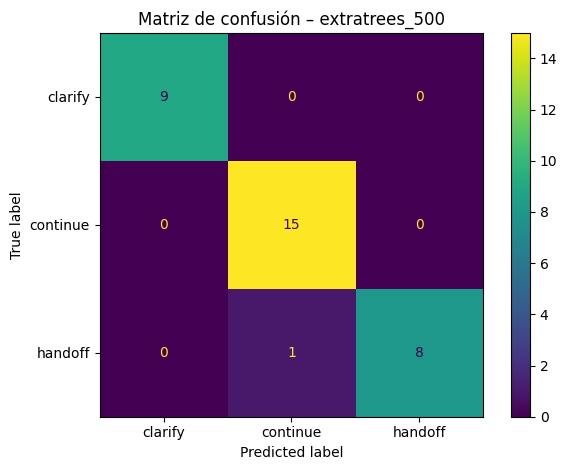

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
fig = plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f'Matriz de confusión – {FINAL_MODEL_NAME}')
plt.tight_layout(); plt.show()


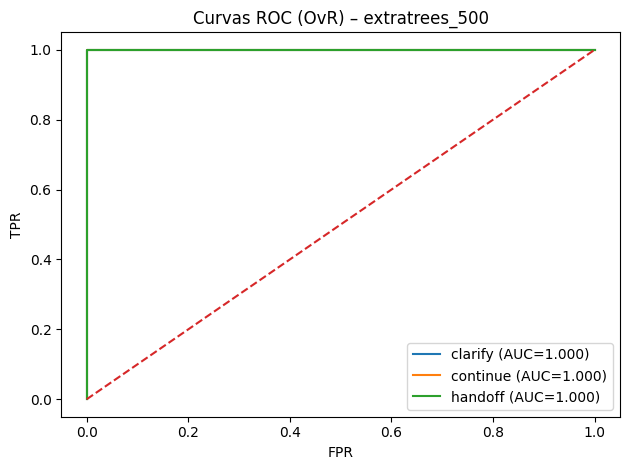

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

classes = np.unique(y_test)
if proba_test is not None:
    if len(classes) == 2 and proba_test.shape[1] == 2:
        fpr, tpr, _ = roc_curve(y_test, proba_test[:,1], pos_label=classes[1])
        auc = roc_auc_score(y_test, proba_test[:,1])
        plt.figure(); plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
        plt.plot([0,1],[0,1],'--'); plt.title(f'Curva ROC – {FINAL_MODEL_NAME}')
        plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.tight_layout(); plt.show()
    else:
        if proba_test.shape[1] == len(classes):
            plt.figure()
            for i, cls in enumerate(classes):
                y_true = (y_test == cls).astype(int)
                fpr, tpr, _ = roc_curve(y_true, proba_test[:, i])
                auc = roc_auc_score(y_true, proba_test[:, i])
                plt.plot(fpr, tpr, label=f'{cls} (AUC={auc:.3f})')
            plt.plot([0,1],[0,1],'--'); plt.title(f'Curvas ROC (OvR) – {FINAL_MODEL_NAME}')
            plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.tight_layout(); plt.show()
        else:
            print('[WARN] Probas no cuadran con n_clases; se omite ROC.')
else:
    print('El modelo final no expone probabilidades; se omite ROC.')


In [15]:
# === Tabla de errores: ejemplos mal clasificados (muestra) ===
errs = pd.DataFrame({
    "y_true": y_test.reset_index(drop=True),
    "y_pred": pd.Series(y_pred).reset_index(drop=True)
})
errs = errs[errs.y_true != errs.y_pred]
display_cols = list(X_test.columns[:10])  # muestra primeras 10 features para inspección rápida
sample = pd.concat([errs.reset_index(drop=True), X_test.reset_index(drop=True).loc[errs.index, display_cols].reset_index(drop=True)], axis=1)
print("Muestras mal clasificadas (primeras 15 filas):")
display(sample.head(15))


Muestras mal clasificadas (primeras 15 filas):


,y_true,y_pred,len_chars_user,len_words_user,question_marks,exclam_marks,n_reprompts_similar,tool_error,tool_timeout,tool_error_or_timeout,confidence_sim,intent_margin_sim
0,handoff,continue,0.7655,0.923708,-0.517413,0.0,-0.264953,-0.243332,-0.137795,-0.28379,0.241253,-0.256511


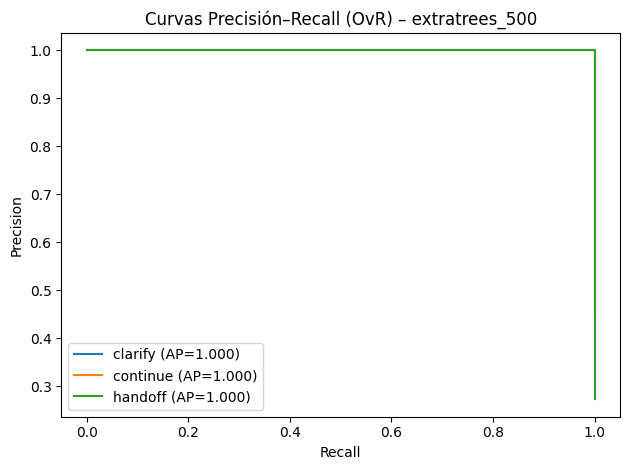

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

if proba_test is not None:
    if len(classes) == 2 and proba_test.shape[1] == 2:
        precision, recall, _ = precision_recall_curve(y_test, proba_test[:,1], pos_label=classes[1])
        ap = average_precision_score(y_test, proba_test[:,1])
        plt.figure(); plt.plot(recall, precision, label=f'AP={ap:.3f}')
        plt.title(f'Curva Precisión–Recall – {FINAL_MODEL_NAME}')
        plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend(); plt.tight_layout(); plt.show()
    else:
        if proba_test.shape[1] == len(classes):
            plt.figure()
            for i, cls in enumerate(classes):
                y_true = (y_test == cls).astype(int)
                precision, recall, _ = precision_recall_curve(y_true, proba_test[:, i])
                ap = average_precision_score(y_true, proba_test[:, i])
                plt.plot(recall, precision, label=f'{cls} (AP={ap:.3f})')
            plt.title(f'Curvas Precisión–Recall (OvR) – {FINAL_MODEL_NAME}')
            plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend(); plt.tight_layout(); plt.show()
        else:
            print('[WARN] Probas no cuadran con n_clases; se omiten PR.')
else:
    print('El modelo final no expone probabilidades; se omite PR.')


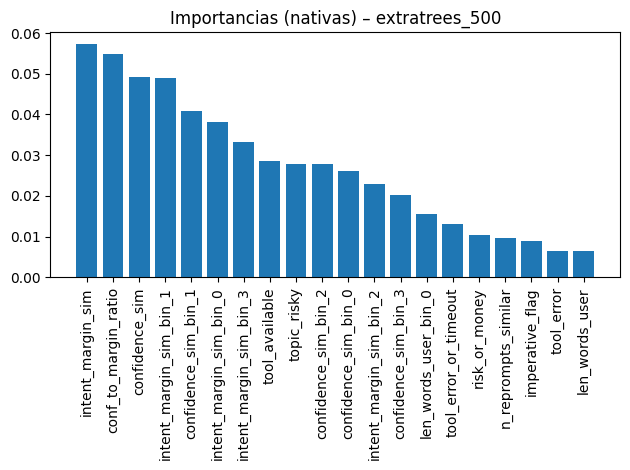

In [17]:
from sklearn.inspection import permutation_importance
from sklearn.base import clone

TOPN = 20
def plot_topn(names, values, title):
    import numpy as _np
    idx = _np.argsort(values)[::-1][:TOPN]
    plt.figure(); plt.bar(range(len(idx)), _np.array(values)[idx])
    plt.xticks(range(len(idx)), _np.array(names)[idx], rotation=90)
    plt.title(title); plt.tight_layout(); plt.show()

try:
    clf = getattr(final_estimator, 'named_steps', {}).get('clf', final_estimator)
    if hasattr(clf, 'feature_importances_'):
        vals = clf.feature_importances_
        plot_topn(np.array(num_cols), vals, f'Importancias (nativas) – {FINAL_MODEL_NAME}')
    elif hasattr(clf, 'coef_'):
        coefs = clf.coef_
        if getattr(coefs, 'ndim', 1) > 1:
            import numpy as _np
            coefs = _np.mean(_np.abs(coefs), axis=0)
        else:
            coefs = np.abs(coefs)
        plot_topn(np.array(num_cols), coefs, f'Coeficientes (|coef|) – {FINAL_MODEL_NAME}')
    else:
        raise AttributeError('Sin importancias nativas; usar permutación.')
except Exception as e:
    print('[INFO] Importancias nativas no disponibles:', e)
    pipe = clone(final_estimator)
    pipe.fit(X_train, y_train)
    pi = permutation_importance(pipe, X_test, y_test, n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1, scoring='f1_macro')
    plot_topn(np.array(num_cols), pi.importances_mean, f'Permutation Importance – {FINAL_MODEL_NAME}')


## Conclusiones  
- Se exploraron ensambles homogéneos y heterogéneos con tuning.  
- Se consolidó una tabla comparativa con F1‑macro (principal), accuracy, precision‑macro, recall‑macro y tiempos.  
- El modelo final seleccionado se justifica por rendimiento, estabilidad (STD CV) y costo; se mantienen resultados sólidos en test.  
- Las gráficas (matriz de confusión, ROC/PR, importancias) permiten interpretar el comportamiento del modelo y áreas de mejora.

In [18]:
# === Exportar pipeline final y versiones ===
import joblib, sys, sklearn, numpy, pandas
joblib.dump(final_estimator, "modelo_final.joblib")
print("Guardado modelo_final.joblib")
print("Versiones -> sklearn:", sklearn.__version__, "| numpy:", numpy.__version__, "| pandas:", pandas.__version__)

infer = '''#!/usr/bin/env python3
import sys, joblib, pandas as pd
from pathlib import Path
mdl = joblib.load("modelo_final.joblib")
inp = Path(sys.argv[1])
df = pd.read_csv(inp)
pred = mdl.predict(df.drop(columns=["final_label"], errors="ignore"))
pd.DataFrame({"pred": pred}).to_csv("predicciones.csv", index=False)
print("Listo: predicciones.csv")
'''
with open("predict.py","w",encoding="utf-8") as f:
    f.write(infer)
print("Creado predict.py")


Guardado modelo_final.joblib
Versiones -> sklearn: 1.5.2 | numpy: 2.1.1 | pandas: 2.2.3
Creado predict.py


---  
**Notas de reproducibilidad**  
- `RANDOM_STATE = 42` y preprocesamiento consistente con Avance 4.  
- Ejecutar la libreta secuencialmente.  
- Puede ajustarse `FINAL_MODEL_NAME` para forzar la elección final.